In [ ]:
#| hide
from ready_steady_go.benchmark import *

# Ready, Steady, Go!



It's fall 2022, and for the first time in years, buying a GPU for Deep Learning experiments does not sound too crazy.

Now, how do we pick one?

> Keep in mind, performance depends on many factors, not least your CPU and often SSD.\
> For experiments, you might be better off with 2 cheaper GPUs - one to run in background, the other used interactively.



# My Results

In [ ]:
# |code-fold: true
# |code-summary: "Imports"
# |eval: false

import wandb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


I ran the benchmark on a variety of GPUs from [vast.ai](https://vast.ai).
The results are automatically synced to [Weights & Biases](https://wandb.ai). 

In [8]:
# |code-fold: true
# |code-summary: "Retrieve and clean up data"
# |eval: false

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

api = wandb.Api()

runs = api.runs("xl0/ready-steady-go")
summaries = [ dict(r.summary) | {"id": r.id} for r in runs if r.state == "finished"]

df = pd.DataFrame.from_records(summaries)

df = df[["device_name", "model", "bs", "fp16", "throughput"]]
df["fp16"] = df["fp16"].apply(lambda x: "FP16" if x else "FP32")
df = df.replace({"device_name" : {
                        "NVIDIA*": "",
                        "GeForce": "",
                        "Tesla": "",
                        "-": " "}}, regex=True)
df.dropna(inplace=True)

# For each model, normalize performance by top throughput.
for model in df.model.unique():
    df.loc[ df.model == model, "throughput"] /= df.loc[df.model == model, "throughput"].max()
df["throughput"] *= 100

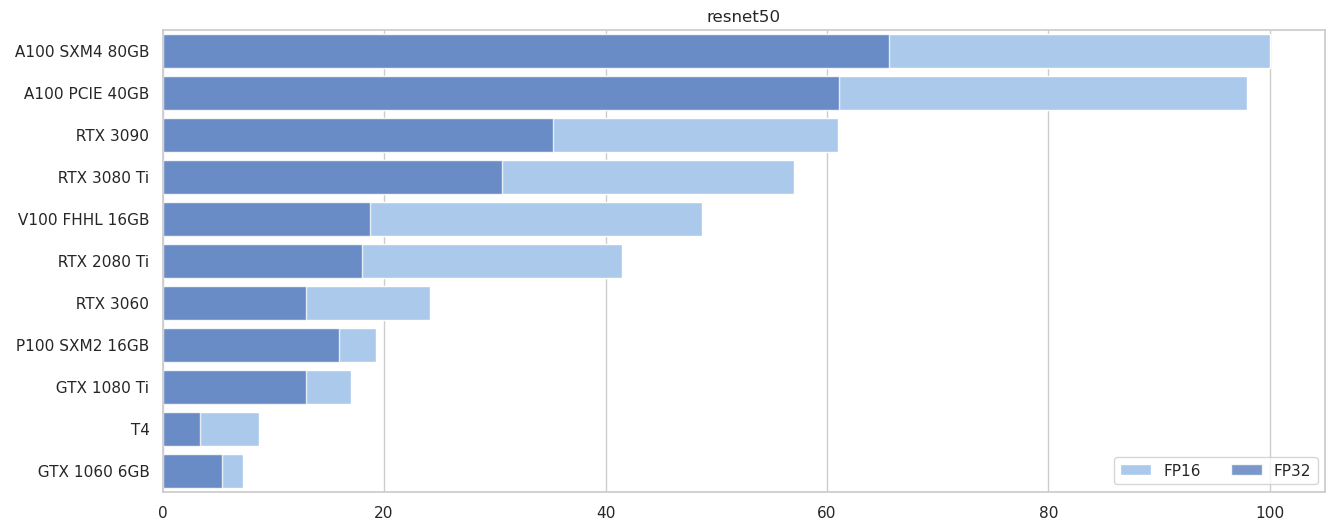

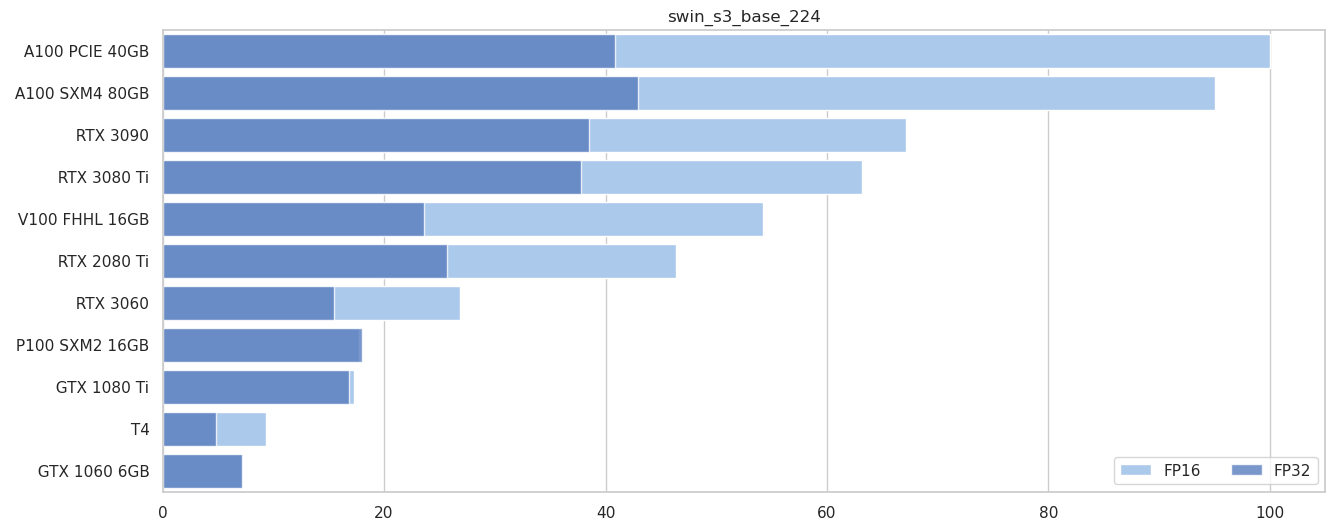

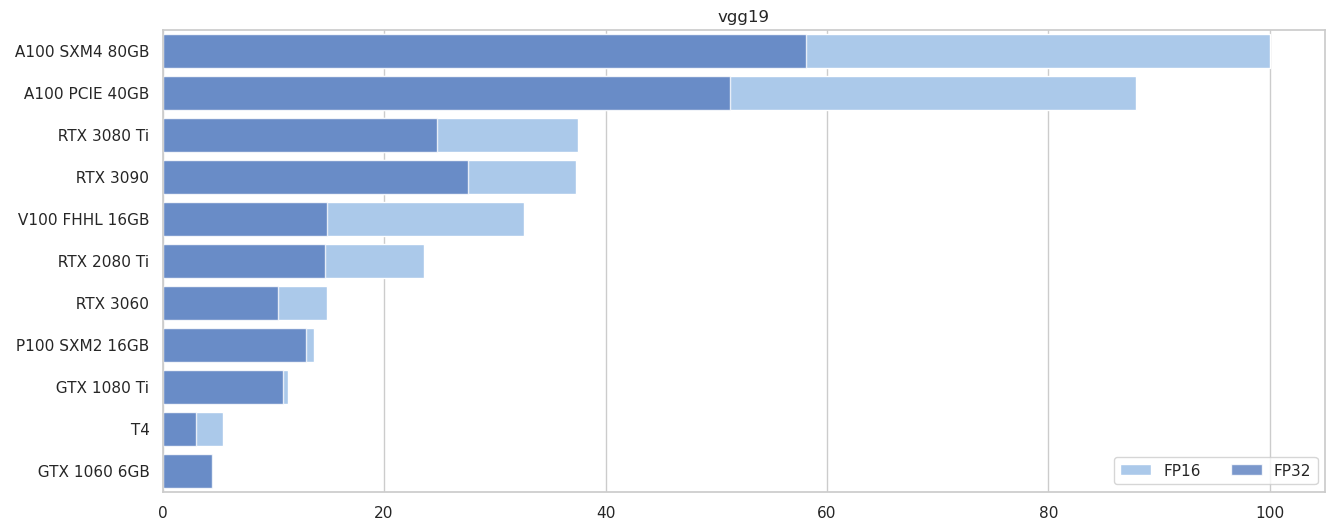

In [9]:
# |code-fold: true
# |code-summary: "Plot GPU performance"
# |eval: false

# For each device+model+fp, get the index of the entry with the highest throughput.
max_bs_idx = df.groupby(["device_name", "model", "fp16"])["throughput"].idxmax()

for model in df.model.unique():   
    f, ax = plt.subplots(figsize=(15, 6))
    
    tops = df.loc[max_bs_idx].query(f"model == '{model}'").sort_values("throughput", ascending=False)

    sns.set_color_codes("pastel")
    sns.barplot(ax=ax, data=tops.query("fp16 == 'FP16'"),
                x="throughput", y="device_name", label="FP16", color="b", alpha=1)

    sns.set_color_codes("muted")
    sns.barplot(ax=ax, data=tops.query("fp16 == 'FP32'"),
                x="throughput", y="device_name", label="FP32", color="b", alpha=0.8,
                order=tops.query("fp16 == 'FP16'").sort_values("throughput", ascending=False).device_name)

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=None, xlabel=None, title=model)


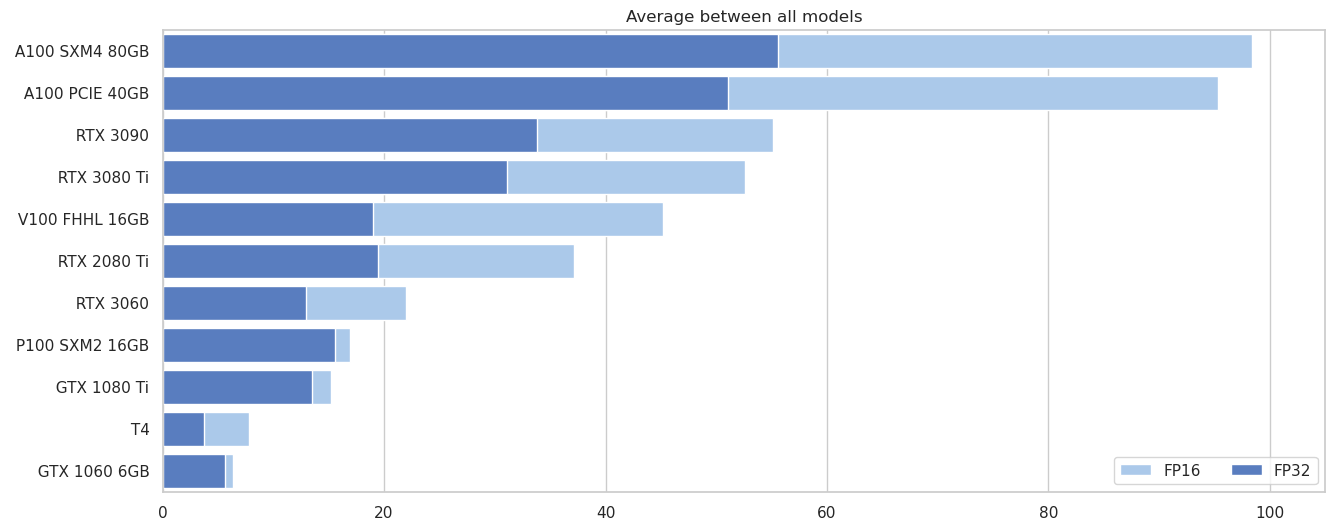

In [ ]:
# |code-fold: true
# |code-summary: "Average"
# |eval: false

f, ax = plt.subplots(figsize=(15, 6))

tops = df.loc[max_bs_idx].sort_values("throughput", ascending=False)
# tops


fp16s = df.loc[max_bs_idx].query("fp16=='FP16'")
grouped = fp16s.groupby(["device_name"], as_index=False)["throughput"]

display_order = grouped.mean().sort_values("throughput", ascending=False)


sns.set_color_codes("pastel")
tt= sns.barplot(ax=ax, data=tops.loc[tops.fp16.eq('FP16')],
            x="throughput", y="device_name", label="FP16", color="b", errwidth=0,
            order=display_order.device_name)

# f, ax = plt.subplots(figsize=(15, 6))

sns.set_color_codes("muted")
sns.barplot(ax=ax, data=tops.loc[tops.fp16.eq('FP32')],
            x="throughput", y="device_name", label="FP32", color="b", errwidth=0,
            order=display_order.device_name)
        

ax.legend(ncol=2, loc="lower right", frameon=True)
_ = ax.set(ylabel=None, xlabel=None, title="Average between all models")

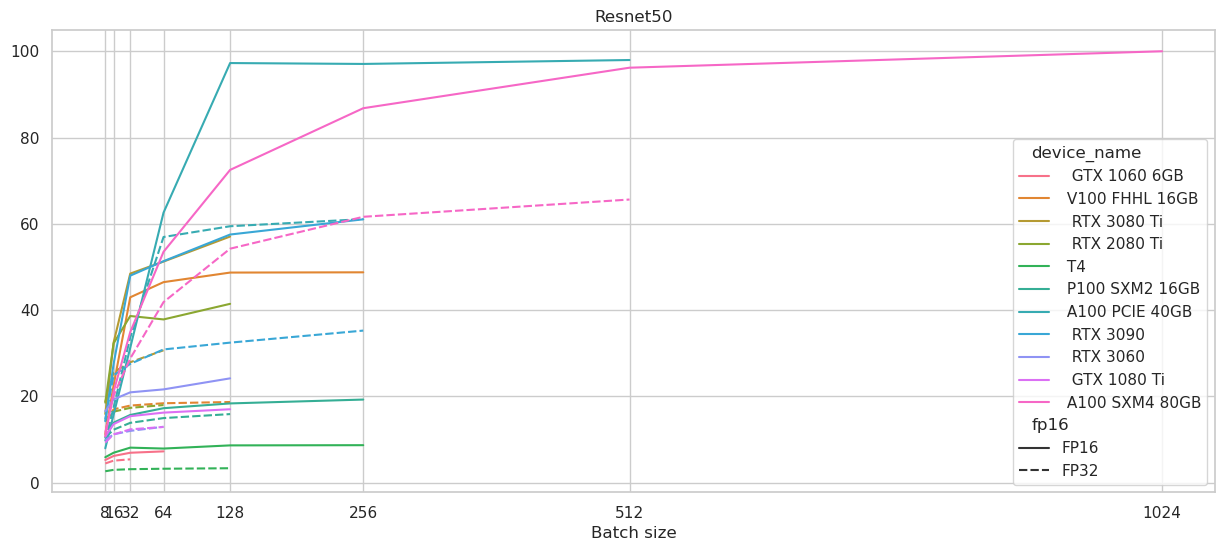

In [10]:
# |hide
# |eval: false

df["line"] = df["device_name"] + " " + df["fp16"]
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(ax=ax, data=df.query("model=='resnet50'"), x="bs", y="throughput", hue="device_name", style="fp16")
ax.set_ylabel(None)
ax.set_xlabel("Batch size")
ax.set_title("Resnet50")
_ = ax.set_xticks([8,16,32,64,128,256,512,1024])